In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

### Data Visualization

In [2]:
df = pd.read_csv('2024_oct_nov_mbta.csv')

In [3]:
df['service_date'] = pd.to_datetime(df['service_date'])
df['stop_departure_datetime'] = pd.to_datetime(df['stop_departure_datetime'])

### 4 Side-By-Side Boxplots for Headways

In [4]:
df['day_type'] = np.where(df['service_date'].dt.weekday < 5, 'weekday', 'weekend')

In [5]:
#create new dataframe with dates with the average headway duration for that day
df['service_date'] = pd.to_datetime(df['service_date'])
avg_df = df.groupby('service_date')['headway_trunk_seconds'].mean().reset_index()
avg_df.columns = ['service_date', 'avg_headway']

#splitting data into weekdays vs. weekends for both weeks and store average headway
w1_weekdays = pd.to_datetime(['2024-10-01', '2024-10-02', '2024-10-03', '2024-10-04', '2024-10-07'])
w1_weekend = pd.to_datetime(['2024-10-05', '2024-10-06'])
w2_weekdays = pd.to_datetime(['2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-11'])
w2_weekend = pd.to_datetime(['2024-11-09', '2024-11-10'])

def get_avg_data(dates):
  return avg_df[avg_df['service_date'].isin(dates)]['avg_headway']

w1_wd, w1_we = get_avg_data(w1_weekdays), get_avg_data(w1_weekend)
w2_wd, w2_we = get_avg_data(w2_weekdays), get_avg_data(w2_weekend)

In [6]:
#initialize + scale weekday vs. weekend data
wd_data = pd.concat([w1_wd, w2_wd])
wd_y_min = wd_data.min() * 0.95
wd_y_max = wd_data.max() * 1.05 #setting consistent y scale for weekdays

we_data = pd.concat([w1_we, w2_we])
we_y_min = we_data.min() * 0.95
we_y_max = we_data.max() * 1.05 #setting consistent y scale for weekends

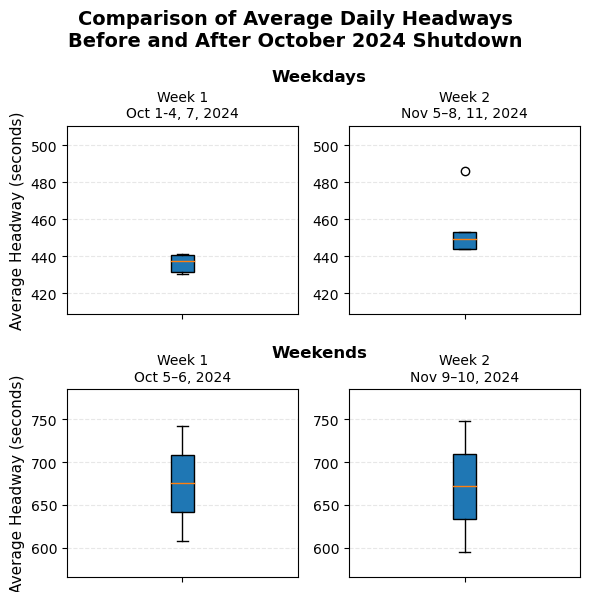

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten()

plots = [('Week 1\nOct 1-4, 7, 2024', w1_wd, wd_y_min, wd_y_max),
         ('Week 2\nNov 5–8, 11, 2024', w2_wd, wd_y_min, wd_y_max),
         ('Week 1\nOct 5–6, 2024', w1_we, we_y_min, we_y_max),
         ('Week 2\nNov 9–10, 2024', w2_we, we_y_min, we_y_max)]

for ax, (title, data, y_min, y_max) in zip(axes, plots):
  ax.boxplot([data], patch_artist=True, widths=0.1)
  ax.set_title(title, fontsize=10)
  if ax in [axes[0], axes[2]]:
    ax.set_ylabel('Average Headway (seconds)', fontsize=11)
  ax.set_xticklabels([''])
  ax.grid(axis='y', alpha=0.3, linestyle='--')
  ax.set_ylim(y_min, y_max)

fig.suptitle('Comparison of Average Daily Headways\nBefore and After October 2024 Shutdown\n',
             fontsize=14, fontweight='heavy')
fig.text(0.54, 0.86, 'Weekdays', ha='center', fontsize=12, fontweight = 'semibold')
fig.text(0.54, 0.4, 'Weekends', ha='center', fontsize=12, fontweight = 'semibold')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


### Dual Barcharts showing headway improvement by stop

In [8]:
#splitting data into weekdays vs. weekends for both weeks and store average headway, this time groupiing by stop names
def get_avg_data_stops(dates):
  filtered_df = df[df['service_date'].isin(dates)]
  return filtered_df.groupby('stop_name')['headway_trunk_seconds'].mean()

w1_wd_avg, w1_we_avg = get_avg_data_stops(w1_weekdays), get_avg_data_stops(w1_weekend)
w2_wd_avg, w2_we_avg = get_avg_data_stops(w2_weekdays), get_avg_data_stops(w2_weekend)

In [9]:
#create new dataframe sorted by weekly improvements
def weekly_improvement_calc(w1, w2):
  comparison_df = pd.DataFrame({'week1': w1, 'week2': w2}).dropna()
  comparison_df['improvement'] = comparison_df['week1'] - comparison_df['week2']
  return comparison_df.sort_values('improvement', ascending=False)

wd_comparison_df = weekly_improvement_calc(w1_wd_avg, w2_wd_avg)
we_comparison_df = weekly_improvement_calc(w1_we_avg, w2_we_avg)

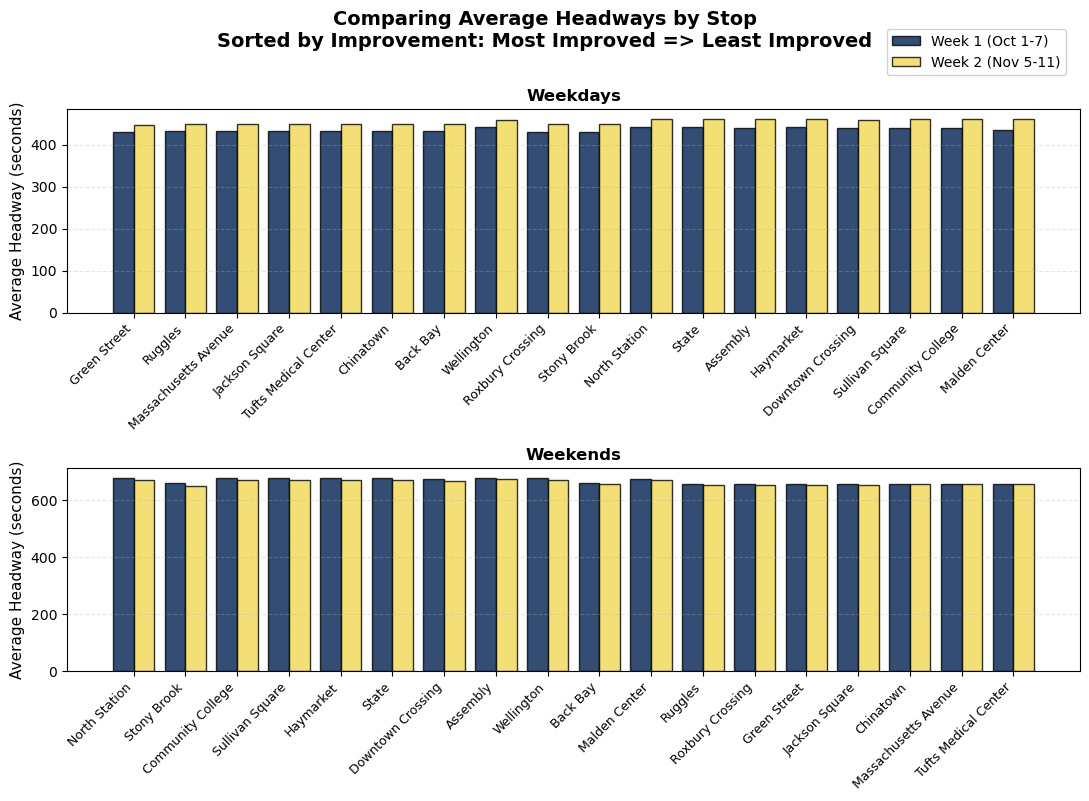

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(11, 8))
width = 0.4
c = ['#002051', '#f0d752']

plots = [(wd_comparison_df, 'Weekdays', 'Week 1 (Oct 1-4, 7)', 'Week 2 (Nov 5-8, 11)'),
         (we_comparison_df, 'Weekends', 'Week 1 (Oct 5-6)', 'Week 2 (Nov 9-10)')]

for ax, (comp_df, title, w1_label, w2_label) in zip(axes, plots):
    x = np.arange(len(comp_df))
    w1_bar = ax.bar(x-width/2, comp_df['week1'], width, label=w1_label, color=c[0], edgecolor='black', alpha=0.8)
    w2_bar = ax.bar(x+width/2, comp_df['week2'], width, label=w2_label, color=c[1], edgecolor='black', alpha=0.8)

    ax.set_ylabel('Average Headway (seconds)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comp_df.index, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

labels = ['Week 1 (Oct 1-7)', 'Week 2 (Nov 5-11)']
fig.legend([w1_bar, w2_bar], labels, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10, framealpha=0.9)
fig.suptitle('Comparing Average Headways by Stop\nSorted by Improvement: Most Improved => Least Improved', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.show()

### Line Graph

In [11]:
df['hour'] = df['stop_departure_datetime'].dt.hour
df['week'] = np.where(df['service_date'] <= '2024-10-07', 1, 2)

In [12]:
df.columns

Index(['service_date', 'route_id', 'trunk_route_id', 'trip_id', 'direction_id',
       'direction', 'parent_station', 'stop_id', 'stop_name',
       'stop_departure_datetime', 'stop_departure_sec',
       'headway_trunk_seconds', 'day_type', 'hour', 'week'],
      dtype='object')

In [13]:
wd_headways = df.query('day_type == "weekday"').groupby(['week', 'hour'])['headway_trunk_seconds'].mean().reset_index()
we_headways = df.query('day_type == "weekend"').groupby(['week', 'hour'])['headway_trunk_seconds'].mean().reset_index()
for headway_df in [wd_headways, we_headways]:
  headway_df.rename(columns={'headway_trunk_seconds': 'avg_headways'}, inplace=True)
  headway_df['avg_headways'] = headway_df['avg_headways'].round(2)
  for hour in [2, 4]:
    headway_df.loc[len(headway_df)] = [1, hour, 0]
    headway_df.loc[len(headway_df)] = [2, hour, 0]

In [14]:
import altair as alt

In [15]:
input_radio = alt.binding_radio(name='Weeks: ', options=[None, 1, 2], labels=['Both', '1', '2'])
radio = alt.param(name='radio', bind=input_radio, value=None)
scale = alt.Scale(domain=[1, 2], range=['#002051', '#f0d752'])

weekday = alt.Chart(wd_headways).mark_line(point=True).encode(
    x = alt.X('hour:O'),
    y = alt.Y('avg_headways:Q'),
    color = alt.condition((alt.datum.week == radio) | (radio == None), alt.Color('week:N', scale=scale), alt.value('grey')),
    opacity = alt.condition((alt.datum.week == radio) | (radio == None), alt.value(1), alt.value(0.1)),
    tooltip=['week:N', 'hour:O', 'avg_headways:Q']
).add_params(
    radio
).properties(
    width = 600,
    height = 300,
    title = 'Weekday Orange Line Headways'
)

weekend = alt.Chart(we_headways).mark_line(point=True).encode(
    x = alt.X('hour:O'),
    y = alt.Y('avg_headways:Q'),
    color = alt.condition((alt.datum.week == radio) | (radio == None), alt.Color('week:N', scale=scale), alt.value('grey')),
    opacity = alt.condition((alt.datum.week == radio) | (radio == None), alt.value(1), alt.value(0.1)),
    tooltip=['week:N', 'hour:O', 'avg_headways:Q']
).add_params(
    radio
).properties(
    width = 600,
    height = 300,
    title = 'Weekend Orange Line Headways'
)

weekday | weekend

alt.HConcatChart(...)

In [16]:
# Your data prep (make sure this is already run)
df['stop_departure_datetime'] = pd.to_datetime(df['stop_departure_datetime'])
df['hour'] = df['stop_departure_datetime'].dt.hour
df['week'] = np.where(df['service_date'] <= '2024-10-07', 1, 2)

# Calculate headways in minutes
wd_headways = df[df['day_type'] == 'weekday'].groupby(['week', 'hour'])['headway_trunk_seconds'].mean() / 60
we_headways = df[df['day_type'] == 'weekend'].groupby(['week', 'hour'])['headway_trunk_seconds'].mean() / 60

wd_headways = wd_headways.round(2).reset_index().rename(columns={'headway_trunk_seconds': 'avg_headways'})
we_headways = we_headways.round(2).reset_index().rename(columns={'headway_trunk_seconds': 'avg_headways'})

# Exact colors from your bar chart
scale = alt.Scale(domain=[1, 2], range=['#002051', '#f0d752'])

# Radio button
radio = alt.binding_radio(options=[None, 1, 2], labels=['Both', 'Week 1 (Pre)', 'Week 2 (Post)'], name='Weeks: ')
select_week = alt.param(bind=radio, value=None)

# Color and opacity (colors always visible, only fade unselected)
color = alt.Color('week:N', scale=scale, legend=None, title='Period')
opacity = alt.condition(
    (alt.datum.week == select_week) | (select_week == None),
    alt.value(1.0),
    alt.value(0.2)
)

# Weekday chart
weekday_chart = alt.Chart(wd_headways).mark_line(point=alt.OverlayMarkDef(size=80, filled=True)).encode(
    x=alt.X('hour:O', title='Hour of Day'),
    y=alt.Y('avg_headways:Q', title='Average Headway (minutes)'),
    color=color,
    opacity=opacity,
    strokeDash=alt.value([6,0]),  # solid line
    tooltip=['week:N', 'hour:O', 'avg_headways:Q']
).properties(
    title='Weekday Headways',
    width=500,
    height=420
).add_params(select_week)

# Weekend chart
weekend_chart = alt.Chart(we_headways).mark_line(point=alt.OverlayMarkDef(size=80, filled=True)).encode(
    x=alt.X('hour:O', title='Hour of Day'),
    y=alt.Y('avg_headways:Q', title='Average Headway (minutes)'),
    color=color,
    opacity=opacity,
    strokeDash=alt.value([10,5]),  # dashed line
    tooltip=['week:N', 'hour:O', 'avg_headways:Q']
).properties(
    title='Weekend Headways',
    width=500,
    height=420
).add_params(select_week)

# Combine side by side
final_chart = (weekday_chart | weekend_chart).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=18
)

final_chart.save('headway_line_interactive.html')

Design justification:
• Mark: Line — gives us insight to headways at different times of the day
• X-position: categorical combination of period (pre/post) + day_type (weekday/weekend)
• Y-position: average_headway_seconds:Q (primary quantitative key)
• Static format: the critical insight ("reliability did not improve at all") is immediately obvious from the nearly identical boxes — no interaction needed
• Separate panels for weekdays vs. weekends respect different service patterns

### MAP

In [17]:
STATIONLOCS = {'Oak Grove': [42.436710697872506, -71.07092503350304], 'Malden Center': [42.426715054301724, -71.0742494072706],
               'Wellington': [42.402294710280856, -71.07695931633984], 'Assembly': [42.392806031674816, -71.07712767952755],
               'Sullivan Square': [42.38397982837347, -71.07687820052895], 'Community College': [42.37364176211696, -71.06968424389598],
               'North Station': [42.36637544875684, -71.06191354476536], 'Haymarket': [42.3628527768202, -71.05822862533881],
               'State': [42.35880709749407, -71.05764134103336], 'Downtown Crossing': [42.35545700180955, -71.06032872870097],
               'Chinatown': [42.35229276374171, -71.06252887008564], 'Tufts Medical Center': [42.34963189903043, -71.06382599632579],
               'Back Bay': [42.34732022260072, -71.07577517133004], 'Massachusetts Avenue': [42.341447784246036, -71.08326060618234],
               'Ruggles': [42.3365788551873, -71.08920066161751], 'Roxbury Crossing': [42.33132609480257, -71.09542804854041],
               'Jackson Square': [42.323098213457314, -71.09977299407247], 'Stony Brook': [42.317074031538034, -71.10423530764933],
               'Green Street': [42.31042957679869, -71.10745247372988], 'Forest Hills': [42.30060904670217, -71.11384453589027]}

#create south-north index of stations so we can measure only consecutive stations
STATIONPOS = {station: idx for idx, station in enumerate(reversed(STATIONLOCS.keys()))}

In [18]:
def is_consecutive(station1, station2):
    '''check if two stations are consecutive
       params: station1, station2, (str)
       returns: bool True/False'''
    if station1 not in STATIONPOS or station2 not in STATIONPOS:
        return False  # irregular station names

    pos1 = STATIONPOS[station1]
    pos2 = STATIONPOS[station2]
    return abs(pos1 - pos2) == 1  # return True if stations differ by 1 position


def hav_distance(lat1, long1, lat2, long2):
    '''haversine distance in miles between two coordinate pairs
       params: lat1, long1, lat2, long2, (float)
       returns: distance in miles, (float)'''

    lat1_rad, lat2_rad = np.radians(lat1), np.radians(lat2)  # convert to radians
    delta_lat, delta_long = np.radians(lat2 - lat1), np.radians(long2 - long1)
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_long / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return 3956 * c  # convert from rads to miles by multiplying by earth's radius


def agg_segments(station1, station2):
    '''combines the north->south and south->north variants of the same
       station pair to calculate the combined speed for each:
       e.g. State->Haymarket (North/Outbound) and Haymarket->State (South/Inbound)
       are both aggregated into State->Haymarket (both NB and SB)'''
    if STATIONPOS[station1] < STATIONPOS[station2]:
        return f'{station1} -> {station2}'
    else:
        return f'{station2} -> {station1}'


def calculate_speed(df, stationlocs):
    '''speed calculations for all consecutive stations on each trip
       params: df (Dataframe),
               stationlocs: dict with shape stationname(str): [lat, long]
       returns: dataframe including lat/long and speeds between stations'''
    speeds = []
    # counter for # of times data is skipped due to non-consecutive stations,
    # unreasonable time between stations, or unreasonable speeds
    exclusions = {}

    df = df.sort_values(['trip_id', 'stop_departure_datetime'])
    print(f"{len(df['trip_id'].unique())} trips")

    for trip_id in df['trip_id'].unique():
        trip_df = df[df['trip_id'] == trip_id].sort_values('stop_departure_datetime')
        # print(trip_df)

        for i in range(len(trip_df) - 1):
            r1, r2 = trip_df.iloc[i], trip_df.iloc[i + 1]  # two rows
            s1, s2 = r1['stop_name'], r2['stop_name']  # two stations

            if s1 in STATIONPOS and s2 in STATIONPOS:
                seg_name = agg_segments(s1, s2)
                # setup measurements of included/exclude datapoints for tooltip info
                if seg_name not in exclusions:
                    exclusions[seg_name] = {
                        'skipped_nc': 0,  # num of data skipped for non-consec station pairs
                        'skipped_t': 0,  # num of data skipped for unreasonable time diff
                        'skipped_speed': 0,  # ''' for unreasonable speed calculations
                        'valid_measurements': 0}  # total of non-excluded datapoints

            if not is_consecutive(s1, s2):  # exclude+count non-consecutive stations
                if seg_name in exclusions:
                    exclusions[seg_name]['skipped_nc'] += 1
                continue

            if s1 in stationlocs and s2 in stationlocs:
                lat1, long1 = stationlocs[s1]  # pull station coords from dict
                lat2, long2 = stationlocs[s2]
                distance = hav_distance(lat1, long1, lat2, long2)  # haversine
                delta_time = (r2['stop_departure_datetime'] - r1[
                    'stop_departure_datetime']).total_seconds() / 3600  # time difference

                # exclude+count data where time between stations is <= 0min or >= 30min
                if delta_time <= 0 or delta_time >= 0.5:
                    exclusions[seg_name]['skipped_t'] += 1
                    continue

                speed = distance / delta_time

                # exclude+count unreasonable speeds (under 1mph or over 100mph)
                if not (1 <= speed <= 100):
                    exclusions[seg_name]['skipped_speed'] += 1
                    continue

                speeds.append({
                    'service_date': r1['service_date'],
                    'trip_id': r1['trip_id'],
                    'station1': s1,
                    'station2': s2,
                    'lat1': lat1,
                    'long1': long1,
                    'lat2': lat2,
                    'long2': long2,
                    'speed_mph': speed,
                    'distance_miles': distance,
                    'time_hrs': delta_time,
                    'time_mins': delta_time * 60,
                    'direction': r1['direction']})

    speeds_df = pd.DataFrame(speeds)

    if len(speeds_df) > 0:  # add exclusion data to speeds dataframe
        speeds_df['seg_name'] = speeds_df.apply(
            lambda row: agg_segments(row['station1'], row['station2']), axis=1)
        speeds_df['skipped_nc'] = speeds_df['seg_name'].map(
            lambda k: exclusions.get(k, {}).get('skipped_nc', 0))
        speeds_df['skipped_t'] = speeds_df['seg_name'].map(
            lambda k: exclusions.get(k, {}).get('skipped_t', 0))

    total_excluded_nc = sum(v['skipped_nc'] for v in exclusions.values())
    total_excluded_t = sum(v['skipped_t'] for v in exclusions.values())
    total_excluded_speed = sum(v['skipped_speed'] for v in exclusions.values())

    print(f'non-consecutive stations skipped: {total_excluded_nc:,}')
    print(f'invalid time diffs skipped: {total_excluded_t:,}')
    print(f'unrealistic speed calculations skipped: {total_excluded_speed:,}')
    #print(f'{len(speeds):,)} valid data points calculated')

    return speeds_df

def speed_subplots(speeds_df, fig, row, col, stationlocs):
    '''Creates a single plotly map showing average speeds between stations with
    a tooltip and a basemap overlay
    params: speeds_df (Dataframe),
            title (str),
            stationlocs (dict)
    returns: plotly figure'''

    if len(speeds_df) == 0:
        return

    #tooltips arent working so im doing this
    # fig.add_trace(
    #     go.Scattermapbox(
    #         lat=[42.35, 42.36],
    #         lon=[-71.08, -71.07],
    #         mode='lines',
    #         line=dict(width=25, color='magenta'),
    #         hovertemplate='<b>DEBUG TEST</b><br>If you see this, tooltips work!<extra></extra>',
    #         hoverlabel=dict(bgcolor='yellow', font=dict(size=16, color='black')),
    #         showlegend=False
    #     ),
    #     row=row, col=col
    # )

    seg_stats = speeds_df.groupby('seg_name').agg({
        'speed_mph': ['mean', 'min', 'max', 'count'],
        'lat1': 'first', 'long1': 'first', 'lat2': 'first', 'long2': 'first',
        'skipped_nc': 'first', 'skipped_t': 'first'}).reset_index()

    seg_stats.columns = ['seg_name', 'avg', 'min', 'max', 'count',
                         'lat1', 'long1', 'lat2', 'long2', 'nc', 't']

    vmin, vmax = seg_stats['avg'].min(), seg_stats['avg'].max() #stats for tooltip

    for _, r in seg_stats.iterrows():
        norm = (r['avg'] - vmin) / (vmax - vmin)
        color = mcolors.to_hex(plt.cm.cividis(norm))
        total = int(r['count'] + r['nc'] + r['t'])

        fig.add_trace( # draw lines
            go.Scattermapbox(
                lat=[r['lat1'], r['lat2']],
                lon=[r['long1'], r['long2']],
                mode='lines',
                line=dict(width=8, color=color),
                hoverinfo='skip',
                showlegend=False
            ),
            row=row, col=col
        )

        # tooltips cannot be added to shapes (at least not easily/in a way i could understand)
        # so i'm creating an invisible marker centered on each line to display the tooltip
        # first we find the midpoint of each marker
        mid_lat = (r['lat1'] + r['lat2']) / 2
        mid_lon = (r['long1'] + r['long2']) / 2

        # then find the segment length to determine marker size
        lat_diff = abs(r['lat2'] - r['lat1'])
        lon_diff = abs(r['long2'] - r['long1'])
        segment_length = np.sqrt(lat_diff ** 2 + lon_diff ** 2)
        marker_size = max(20, min(40, segment_length * 5000))

        tooltip = (
            f"<b>Segment:</b> {r['seg_name']}<br>"
            f"<b>Average Speed:</b> {r['avg']:.1f} mph<br>"
            f"<b>Speed Range:</b> {r['min']:.1f} - {r['max']:.1f} mph<br>"
            f"<b>Included Data Points:</b> {int(r['count'])}<br>"
            f"<b>Excluded (Non-Consecutive):</b> {int(r['nc'])}<br>"
            f"<b>Excluded (Invalid Time):</b> {int(r['t'])}<br>"
            f"<b>Total Data Points:</b> {total}"
        )

        fig.add_trace(
            go.Scattermapbox(
                lat=[mid_lat],
                lon=[mid_lon],
                mode='markers',
                marker=dict(
                    size=marker_size,
                    color=color, #same color as the line
                    opacity=0.01 #invisible
                ),
                text=tooltip,
                hoverinfo='text',
                hoverlabel=dict(
                    bgcolor='white',
                    font=dict(size=12, color='black', family='Arial'),
                    bordercolor='black'
                ),
                showlegend=False
            ),
            row=row, col=col
        )

    lats = [c[0] for c in stationlocs.values()] # get station locations for plotting
    longs = [c[1] for c in stationlocs.values()]
    names = list(stationlocs.keys())

    fig.add_trace(
        go.Scattermapbox(
            lat=lats, lon=longs,
            mode='markers',
            marker=dict(size=8, color='white', opacity=1),
            text=names,
            hovertemplate='<b>%{text}</b><extra></extra>',
            hoverlabel=dict(
                bgcolor='black',
                font=dict(size=12, color='white', family='Arial'),
                bordercolor='white'
            ),
            showlegend=False
        ),
        row=row, col=col
    )

def improvement_subplots(improvement_df, fig, row, col, stationlocs, vmin, vmax):
    '''Calculates the improvement in average speed for each line segment before and after shutdown (second graph)
    '''

    if len(improvement_df) == 0:
        return

    for _, r in improvement_df.iterrows():
        # normalize to scale -1 < 0 < 1
        norm = (r['improvement'] - vmin) / (vmax - vmin)
        # blue (negative improvement) -> white (no improvement) -> red (positive improvement)
        color = mcolors.to_hex(plt.cm.cividis(norm))

        fig.add_trace( # drawing lines, same as before
            go.Scattermapbox(
                lat=[r['lat1'], r['lat2']],
                lon=[r['long1'], r['long2']],
                mode='lines',
                line=dict(width=10, color=color),
                hoverinfo='skip',
                showlegend=False
            ),
            row=row, col=col
        )

        # calculate midpoint of line and marker size, same as before
        mid_lat = (r['lat1'] + r['lat2']) / 2
        mid_long = (r['long1'] + r['long2']) / 2
        lat_diff = abs(r['lat2'] - r['lat1'])
        long_diff = abs(r['long2'] - r['long1'])
        segment_length = np.sqrt(lat_diff ** 2 + long_diff ** 2)
        marker_size = max(20, min(40, segment_length * 5000))

        direction = 'improved' if r['improvement'] > 0 else 'worsened'
        tooltip = (
            f"<b>Segment:</b> {r['seg_name']}<br>"
            f"<b>Speed Change:</b> {r['improvement']:+.1f} mph ({direction})<br>"
            f"<b>Total Data Points:</b> {int(r['total_datapoints'])}"
        )

        # adding the invis markers that display tooltip info
        fig.add_trace(
            go.Scattermapbox(
                lat=[mid_lat],
                lon=[mid_long],
                mode='markers',
                marker=dict(size=marker_size, color=color, opacity=0.01),
                text=tooltip,
                hoverinfo='text',
                hoverlabel=dict(
                    bgcolor='white',
                    font=dict(size=12, color='black', family='Arial'),
                    bordercolor='black'
                ),
                showlegend=False
            ),
            row=row, col=col
        )

    lats = [c[0] for c in stationlocs.values()]  # get station locations for plotting
    longs = [c[1] for c in stationlocs.values()]
    names = list(stationlocs.keys())

    fig.add_trace(
        go.Scattermapbox(
            lat=lats, lon=longs,
            mode='markers',
            marker=dict(size=8, color='white', opacity=1),
            text=names,
            hovertemplate='<b>%{text}</b><extra></extra>',
            hoverlabel=dict(
                bgcolor='black',
                font=dict(size=12, color='white', family='Arial'),
                bordercolor='white'
            ),
            showlegend=False
        ),
        row=row, col=col
    )


def speed_vis(csv, stationlocs):
    ''' generates an interactive plotly figure with 4 subplots to visualize average train speed
    between consecutive station pairs: comparing pre- and post- shutdown and weekdays/weekends
    params: csv (str) - filepath to csv with train data
            stationlocs (dict) - dictionary with station names as keys and station order as values
    returns: speeds_df (pd.DataFrame) - dataframe with average train speed per segment'''

    df = pd.read_csv(csv)
    df['stop_departure_datetime'] = pd.to_datetime(df['stop_departure_datetime'])
    df['service_date'] = pd.to_datetime(df['service_date'])
    speeds_df = calculate_speed(df, stationlocs)

    if len(speeds_df) == 0:
        print('No speed calculations available')
        return

    w1_weekdays = pd.to_datetime(['2024-10-01', '2024-10-02', '2024-10-03', '2024-10-04', '2024-10-07'])
    w2_weekdays = pd.to_datetime(['2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-11'])
    w1_weekend = pd.to_datetime(['2024-10-05', '2024-10-06'])
    w2_weekend = pd.to_datetime(['2024-11-09', '2024-11-10'])

    data = [
        (speeds_df[speeds_df['service_date'].isin(w1_weekdays)], 1, 1, 'Oct 1-4, 7'),
        (speeds_df[speeds_df['service_date'].isin(w2_weekdays)], 1, 2, 'Nov 5-8, 11'),
        (speeds_df[speeds_df['service_date'].isin(w1_weekend)], 2, 1, 'Oct 5-6'),
        (speeds_df[speeds_df['service_date'].isin(w2_weekend)], 2, 2, 'Nov 9-10')]

    comb_fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Oct 1-4, 7, 2024', 'Nov 5-8, 11, 2024', 'Oct 5-6, 2024', 'Nov 9-10, 2024'),
        specs=[[{'type': 'mapbox'}, {'type': 'mapbox'}],
                [{'type': 'mapbox'}, {'type': 'mapbox'}]],
        horizontal_spacing= 0.02, vertical_spacing= 0.1)

    for df_subset, row, col, title in data:
        speed_subplots(df_subset, comb_fig, row, col, stationlocs)

    all_lats = [coords[0] for coords in stationlocs.values()]
    all_longs = [coords[1] for coords in stationlocs.values()]
    center = dict(lat=np.mean(all_lats), lon=np.mean(all_longs))

    for i in range(1,5): # update once for each subplot
        comb_fig.update_layout(**{
            f'mapbox{i}': dict(style='carto-positron', center=center, zoom=10.5) })

    # making a colorbar
    all_speeds = speeds_df.groupby('seg_name')['speed_mph'].mean()
    global_min, global_max = all_speeds.min(), all_speeds.max()
    # 100 colors on the bar
    colorscale = [[i/99, mcolors.to_hex(plt.cm.cividis(i/99))] for i in range(100)]

    comb_fig.add_trace( # adding colorbar to right side of plots
        go.Scattermapbox(
            lat=[center['lat']], lon=[center['lon']], mode='markers',
            marker=dict(size=0.1, color=[global_min], colorscale=colorscale,
                       cmin=global_min, cmax=global_max,
                       colorbar=dict(
                           title=dict(text='Average Speed (mph)', side='right', font=dict(size=12)),
                           thickness=20, len=0.45, x=1.02, y=0.5,
                           tickmode='linear', tick0=global_min, dtick=((global_max-global_min)/5),
                           tickformat='.1f', bordercolor='black', borderwidth=1),
                       showscale=True, opacity=0),
            hoverinfo='skip', showlegend=False),
        row=1, col=2
    )

    comb_fig.update_layout( # update the larger plot and add title
        title='Average Speed Between Stations, Before and After Shutdown (Interactive)</br></br>'
               '<sub><i>Hover over a line segment for statistics</i></sub>',
        title_x = 0.5, title_font_size = 18, height = 1200, margin=dict(t=180),
        showlegend = False, hovermode='closest', hoverdistance=50)

    for a in comb_fig.layout.annotations: #changing titles of subplot
        a.font.size=14
        a.font.color='black'

    comb_fig.write_html('speed_output.html')
    return speeds_df

def improvement_vis(csv, stationlocs):
    ''' generates an interactive plotly figure with 2 subplots to visualize average train speed
        IMPROVEMENT for station pairs: comparing pre- and post- shutdown and weekdays/weekends
        params: csv (str) - filepath to csv with train data
                stationlocs (dict) - dictionary with station names as keys and station order as values
        returns: speeds_df (pd.DataFrame) - dataframe with average train speed improvement per segment'''

    df = pd.read_csv(csv)
    df['stop_departure_datetime'] = pd.to_datetime(df['stop_departure_datetime'])
    df['service_date'] = pd.to_datetime(df['service_date'])
    speeds_df = calculate_speed(df, stationlocs)

    if len(speeds_df) == 0:
        print('No improvement calculations available')
        return

    oct_wd = pd.to_datetime(['2024-10-01', '2024-10-02', '2024-10-03', '2024-10-04', '2024-10-07'])
    nov_wd = pd.to_datetime(['2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-11'])
    oct_we = pd.to_datetime(['2024-10-05', '2024-10-06'])
    nov_we = pd.to_datetime(['2024-11-09', '2024-11-10'])

    # find the average speeds and add to dfs
    oct_wd_speeds = speeds_df[speeds_df['service_date'].isin(oct_wd)].groupby('seg_name').agg({
        'speed_mph': 'mean','lat1': 'first', 'long1': 'first', 'lat2': 'first', 'long2': 'first'}).reset_index()
    oct_wd_speeds.columns = ['seg_name', 'oct_speed', 'lat1', 'long1', 'lat2', 'long2']
    oct_wd_count = speeds_df[speeds_df['service_date'].isin(oct_wd)].groupby('seg_name').size().reset_index(name='oct_count')

    nov_wd_speeds = speeds_df[speeds_df['service_date'].isin(nov_wd)].groupby('seg_name').agg({
        'speed_mph': 'mean'
    }).reset_index()
    nov_wd_speeds.columns = ['seg_name', 'nov_speed']
    nov_wd_count = speeds_df[speeds_df['service_date'].isin(nov_wd)].groupby('seg_name').size().reset_index(name='nov_count')

    oct_we_speeds = speeds_df[speeds_df['service_date'].isin(oct_we)].groupby('seg_name').agg({
        'speed_mph': 'mean',
        'lat1': 'first', 'long1': 'first', 'lat2': 'first', 'long2': 'first'
    }).reset_index()
    oct_we_speeds.columns = ['seg_name', 'oct_speed', 'lat1', 'long1', 'lat2', 'long2']
    oct_we_count = speeds_df[speeds_df['service_date'].isin(oct_we)].groupby('seg_name').size().reset_index(name='oct_count')

    nov_we_speeds = speeds_df[speeds_df['service_date'].isin(nov_we)].groupby('seg_name').agg({
        'speed_mph': 'mean'
    }).reset_index()
    nov_we_speeds.columns = ['seg_name', 'nov_speed']
    nov_we_count = speeds_df[speeds_df['service_date'].isin(nov_we)].groupby('seg_name').size().reset_index(name='nov_count')

    # merge speeds and counts, then calculate difference between months and add counts together
    # fill missing values and drop NAs
    wd_improvement = oct_wd_speeds.merge(nov_wd_speeds, on='seg_name', how='outer')
    wd_improvement = wd_improvement.merge(oct_wd_count, on='seg_name', how='outer')
    wd_improvement = wd_improvement.merge(nov_wd_count, on='seg_name', how='outer')
    wd_improvement['oct_count'] = wd_improvement['oct_count'].fillna(0)
    wd_improvement['nov_count'] = wd_improvement['nov_count'].fillna(0)
    wd_improvement = wd_improvement.dropna(subset=['oct_speed', 'nov_speed'])  # Only keep segments in both periods
    wd_improvement['improvement'] = wd_improvement['nov_speed'] - wd_improvement['oct_speed']
    wd_improvement['total_datapoints'] = wd_improvement['oct_count'] + wd_improvement['nov_count']

    we_improvement = oct_we_speeds.merge(nov_we_speeds, on='seg_name', how='outer')
    we_improvement = we_improvement.merge(oct_we_count, on='seg_name', how='outer')
    we_improvement = we_improvement.merge(nov_we_count, on='seg_name', how='outer')
    we_improvement['oct_count'] = we_improvement['oct_count'].fillna(0)
    we_improvement['nov_count'] = we_improvement['nov_count'].fillna(0)
    we_improvement = we_improvement.dropna(subset=['oct_speed', 'nov_speed'])
    we_improvement['improvement'] = we_improvement['nov_speed'] - we_improvement['oct_speed']
    we_improvement['total_datapoints'] = we_improvement['oct_count'] + we_improvement['nov_count']

    # global stats for colorscale
    all_imps = pd.concat([wd_improvement['improvement'], we_improvement['improvement']])
    global_min, global_max = all_imps.min(), all_imps.max()

    # make the minimum the negative of the maximum so colorbar centers on 0
    barmax = max(abs(global_min), abs(global_max))
    global_min, global_max = -barmax, barmax

    comb_fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Weekday Improvement', 'Weekend Improvement'),
        specs=[[{'type': 'mapbox'}, {'type': 'mapbox'}]],
        horizontal_spacing=0.02, vertical_spacing=0.1)

    # add to subplots
    improvement_subplots(wd_improvement, comb_fig, 1, 1, stationlocs, global_min, global_max)
    improvement_subplots(we_improvement, comb_fig, 1, 2, stationlocs, global_min, global_max)

    all_lats = [coords[0] for coords in stationlocs.values()]
    all_longs = [coords[1] for coords in stationlocs.values()]
    center = dict(lat=np.mean(all_lats), lon=np.mean(all_longs))

    for i in range(1, 3):  # update once for each subplot (only twice this time)
        comb_fig.update_layout(**{
            f'mapbox{i}': dict(style='carto-positron', center=center, zoom=10.5)})

    # making a new diverging colorbar
    n = 100
    # 100 colors on the bar
    colorscale = []
    for i in range(n):
        norm = i / (n-1)
        rgba = plt.cm.cividis(norm)
        color_hex = mcolors.to_hex(rgba)
        colorscale.append([norm, color_hex])

    vals = np.linspace(global_min, global_max, 5)

    comb_fig.add_trace( # i have to do this differently so the tick markers round
        go.Scattermapbox(
            lat=[center['lat']], lon=[center['lon']], mode='markers',
            marker=dict(
                size=0.1,
                color=[0],
                colorscale=colorscale,
                cmin=global_min,
                cmax=global_max,
                colorbar=dict(
                    title = dict(
                        text = 'Change in Average Speed (mph)',
                        side = 'right',
                        font=dict(size=14)
                    ),
                    tickvals=list(vals),
                    ticktext=[f"{v:.1f}" for v in vals],  # <–– one decimal place
                    thickness=20,
                    len=0.6,
                    x=1.02,
                    y=0.5,
                    bordercolor='black',
                    borderwidth=1
                ),
                showscale=True,
                opacity=0
            ),
            hoverinfo='skip',
            showlegend=False
        ),
        row=1, col=2
    )

    comb_fig.update_layout(  # update the larger plot and add title
        title='Improvements in Average Speed Between Stations, Before and After Shutdown (Interactive)</br></br>'
              '<sub><i>Hover over a line segment for statistics</i></sub>',
        title_x=0.5, title_font_size=18, height=1200, margin=dict(t=180),
        showlegend=False, hovermode='closest', hoverdistance=50)

    for a in comb_fig.layout.annotations:  # changing titles of subplot
        a.font.size = 14
        a.font.color = 'black'

    comb_fig.write_html('improvement_output.html')
    return wd_improvement, we_improvement

if __name__ == '__main__':
    csv = '2024_oct_nov_mbta.csv'
    speeds_df = speed_vis(csv, STATIONLOCS)
    wd_imp, we_imp = improvement_vis(csv, STATIONLOCS)
    #fig.show()




728 trips
non-consecutive stations skipped: 1,421
invalid time diffs skipped: 5
unrealistic speed calculations skipped: 9
728 trips
non-consecutive stations skipped: 1,421
invalid time diffs skipped: 5
unrealistic speed calculations skipped: 9
